In [27]:
import pandas as pd
import csv
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import os

from keras.utils import pad_sequences, np_utils
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,load_model
import keras.utils as ku 
import tensorflow
from numpy.random import seed

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [28]:
# Set seeds for reproducability
tensorflow.random.set_seed(2)
seed(1)

In [29]:
df = pd.read_csv('/content/drive/MyDrive/Twitter Text Generation/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=['target_polarity', 'id', 'date', 'flag', 'user', 'text']) 
df

,target_polarity,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [15]:
# Read preprocessed file directly
df = pd.read_csv('/content/drive/MyDrive/Twitter Text Generation/training.1600000.processed.noemoticon.preprocessed.csv',encoding='ISO-8859-1')
df

,Unnamed: 0,target_polarity,id,date,flag,user,text
0,0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww thats bummer shoulda got david...
1,1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many time ball managed save 50 ...
3,3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feel itchy like fire
4,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass behaving im mad cant see
...,...,...,...,...,...,...,...
1598498,1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1598499,1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom cool hear old walt interview Ã¢Â Â«
1598500,1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask detail
1598501,1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th bi hday boo alll time tupac amaru s...


In [ ]:
# To check encoding format of the file
with open('/content/drive/MyDrive/Twitter Text Generation/training.1600000.processed.noemoticon.csv') as f:
    print(f)
f.close()

<_io.TextIOWrapper name='/content/drive/MyDrive/Twitter Text Generation/training.1600000.processed.noemoticon.csv' mode='r' encoding='UTF-8'>


In [ ]:
df.isnull().sum()

target_polarity    0
id                 0
date               0
flag               0
user               0
text               0
dtype: int64

In [32]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
def clean_tweet(text):
    text = re.sub(r'http\S+', ' ', text) # Remove URLs
    text = re.sub(r'@', ' ', text) # Remove @
    text = re.sub(r'#\S+', ' ', text) # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = ' '.join([word.lower() for word in word_tokenize(text)]) # Tokenizing
    return text

In [35]:
df['text'] = df['text'].apply(clean_tweet)
df['text']

0          switchfoot awww thats a bummer you shoulda got...
1          is upset that he cant update his facebook by t...
2          kenichan i dived many times for the ball manag...
3             my whole body feels itchy and like its on fire
4          nationwideclass no its not behaving at all im ...
                                 ...                        
1599995    just woke up having no school is the best feel...
1599996    thewdbcom very cool to hear old walt interview...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy 38th birthday to my boo of alll time tup...
1599999           happy thenspcc sparkscharity speakinguph4h
Name: text, Length: 1600000, dtype: object

In [36]:
df

,target_polarity,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww thats a bummer you shoulda got...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball manag...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im ...
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interview...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday to my boo of alll time tup...


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Phrases'),
 Text(0.5, 1.0, 'Most frequent phrases')]

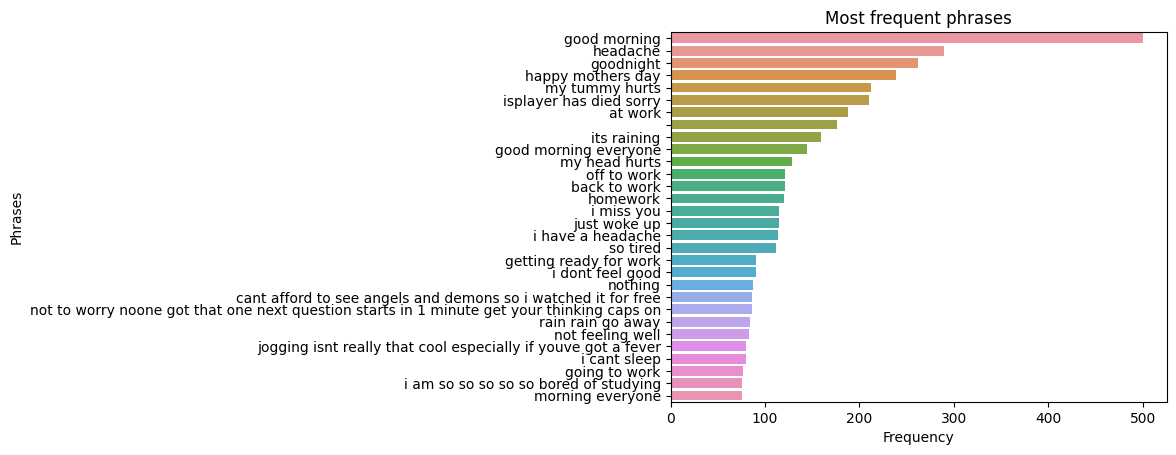

In [37]:
sns.barplot(y=df['text'].value_counts()[:30].index,x=df['text'].value_counts()[:30],orient='h').set(xlabel ="Frequency", ylabel = "Phrases", title ='Most frequent phrases')

In [38]:
df['text'].value_counts()[0:30]

good morning                                                                                  500
headache                                                                                      289
goodnight                                                                                     262
happy mothers day                                                                             239
my tummy hurts                                                                                212
isplayer has died sorry                                                                       210
at work                                                                                       188
                                                                                              176
its raining                                                                                   159
good morning everyone                                                                         144
my head hurts       

In [40]:
patternDel = "get 100 follower[^\"]*" # Removes spam tweets generated by bots
filter = df['text'].str.contains(patternDel)

In [41]:
df = df[~filter] # To only keep the tweets generated by humans
df

,target_polarity,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww thats a bummer you shoulda got...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball manag...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im ...
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interview...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday to my boo of alll time tup...


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Users'),
 Text(0.5, 1.0, 'Tweets generated by user')]

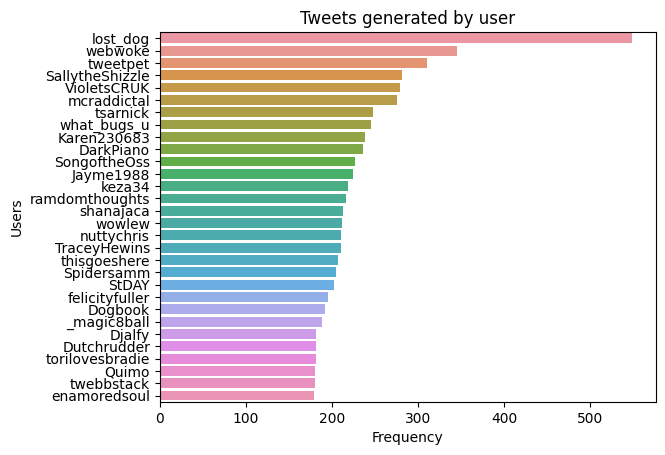

In [42]:
sns.barplot(y=df['user'].value_counts()[:30].index,x=df['user'].value_counts()[:30],orient='h').set(xlabel ="Frequency", ylabel = "Users", title ='Tweets generated by user')

In [43]:
df['user'].value_counts()[:30]

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
SongoftheOss       227
Jayme1988          225
keza34             219
ramdomthoughts     216
shanajaca          213
wowlew             212
nuttychris         211
TraceyHewins       211
thisgoeshere       207
Spidersamm         205
StDAY              202
felicityfuller     195
Dogbook            192
_magic8ball        189
Djalfy             182
Dutchrudder        182
torilovesbradie    182
Quimo              180
twebbstack         180
enamoredsoul       179
Name: user, dtype: int64

In [45]:
# Save preprocessed file
df.to_csv('/content/drive/MyDrive/Twitter Text Generation/training.1600000.processed.noemoticon.preprocessed.csv')

In [47]:
g = gc.collect()
print(g)

68


In [46]:
corpus = []
list_of_users = df['user'].value_counts()[:50].index.tolist()
s = sum(df['user'].value_counts()[:50])
print(list_of_users)
df_filtered = df[df['user'].apply(lambda x:  x in list_of_users)]
d = df_filtered['text'].apply(lambda x: corpus.append(str(x)))
del d
del df_filtered
print(s==len(corpus), s)

['lost_dog', 'webwoke', 'tweetpet', 'SallytheShizzle', 'VioletsCRUK', 'mcraddictal', 'tsarnick', 'what_bugs_u', 'Karen230683', 'DarkPiano', 'SongoftheOss', 'Jayme1988', 'keza34', 'ramdomthoughts', 'shanajaca', 'wowlew', 'nuttychris', 'TraceyHewins', 'thisgoeshere', 'Spidersamm', 'StDAY', 'felicityfuller', 'Dogbook', '_magic8ball', 'Djalfy', 'Dutchrudder', 'torilovesbradie', 'Quimo', 'twebbstack', 'enamoredsoul', 'Broooooke_', 'MTVnHollyWEST23', 'JessMcFlyxxx', 'MiDesfileNegro', 'KevinEdwardsJr', 'linnetwoods', 'insearchofnkotb', 'karinb_za', 'Scyranth', 'JBnVFCLover786', 'cookiemonster82', 'maynaseric', 'hollyalyxfinch', 'shellrawlins', 'mrs_mcsupergirl', 'lesley007', 'DonniesGirl69', 'judez_xo', 'paul_steele', 'bigenya']
True 10299


In [48]:
print(corpus[:10])

['strider is a sick little puppy', 'emily will be glad when mommy is done training at her new job she misses her', 'jade is looking for a new home', 'missxmarisa havent heard from hannah at all yet its very disappointing', 'please watch this vid and tell me if you are not moved', 'scarletjac but not good for me close to my current challenge', 'scarletjac thanks i know that video is harrowing especially the last 2 minutes i must admit i cried', 'sorry i should say that this vid hits you hard please beware the last 2 minutes especially', 'oscartg morning no sun here unfortunately', 'its 840am ive been awake for nearly 2 hours']


In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus) # Updates internal vocabulary of the text lists
total_words = len(tokenizer.word_index) + 1
inp_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0] # Converts tokens of text corpus into a sequence of integers.
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1] # Generates n-gram sequences
    inp_sequences.append(n_gram_sequence)
print(inp_sequences[:10])
print(total_words)

[[5465, 9], [5465, 9, 3], [5465, 9, 3, 377], [5465, 9, 3, 377, 241], [5465, 9, 3, 377, 241, 3660], [3661, 38], [3661, 38, 32], [3661, 38, 32, 224], [3661, 38, 32, 224, 102], [3661, 38, 32, 224, 102, 542]]
14809


In [52]:
max_sequence_len = max([len(x) for x in inp_sequences])
inp_sequences = np.array(pad_sequences(inp_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = inp_sequences[:,:-1],inp_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)
print(len(label))

111918


In [53]:
input_len = max_sequence_len - 1
model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 10)            148090    
                                                                 
 lstm_2 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 14809)             1495709   
                                                                 
Total params: 1,688,199
Trainable params: 1,688,199
Non-trainable params: 0
_________________________________________________________________


In [54]:
record = model.fit(predictors, label, epochs=100)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [55]:
# Save model
model.save("/content/drive/MyDrive/Twitter Text Generation/tweet_gen.h5")

In [ ]:
# Load pre-trained model
model = load_model("/content/drive/MyDrive/Twitter Text Generation/tweet_gen.h5")

In [56]:
corpus

['strider is a sick little puppy',
 'emily will be glad when mommy is done training at her new job she misses her',
 'jade is looking for a new home',
 'missxmarisa havent heard from hannah at all yet its very disappointing',
 'please watch this vid and tell me if you are not moved',
 'scarletjac but not good for me close to my current challenge',
 'scarletjac thanks i know that video is harrowing especially the last 2 minutes i must admit i cried',
 'sorry i should say that this vid hits you hard please beware the last 2 minutes especially',
 'oscartg morning no sun here unfortunately',
 'its 840am ive been awake for nearly 2 hours',
 'jason2008 hello im out of coffee this morningthats what i get for winding you up yesterday lol have a good day',
 'kingkiwi i want to be somewhere with no rain its not very nice here today',
 'does anyone else miss chatting in chat rooms i do but cant find one i feel comfortable in suggestions please',
 'and i am now a division of one',
 'seamonkey86 i 

In [59]:
def generate_text(seed_text,n_words):
    text = []
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded],maxlen = max_sequence_len-1,truncating = 'pre')  
        y_predict = np.argmax(model.predict(encoded), axis=-1)
        predicted_words = " "
        for word,index in tokenizer.word_index.items():
            if index == y_predict:
                predicted_word = word
                break
        seed_text = seed_text + " " + predicted_word
        text.append(predicted_word)
    return " ".join(text)

In [61]:
print(generate_text(corpus[4],20))
print(generate_text(corpus[5],20))
print(generate_text(corpus[6],20))

1/1 [==============================] - 0s 22ms/step
to be a month with the guys i have to go to work and see me and i am so
1/1 [==============================] - 0s 18ms/step
lol i have to watch to the death later to get it again xx cant wait to rest and xx
1/1 [==============================] - 0s 18ms/step
like out and and well bn up while its not a lil whore love you amp i am last night
